In [1]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import scanpy as sc
import scvi
import seaborn as sns
from scvi.external import MRVI

/home/user/anaconda3/envs/scvi-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scvi.settings.seed = 0  # optional: ensures reproducibility
print("Last run with scvi-tools version:", scvi.__version__)
save_dir = "/home/user/Documents/Kinase_project/figures/PDN_Tcells/mrvi/saved_models/"
output_dir = os.path.join("/home/user/Documents/Kinase_project/figures/PDN_Tcells/mrvi/saved_outputs/")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
figure_dir = os.path.join("/home/user/Documents/Kinase_project/figures/PDN_Tcells/mrvi/figures/")
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
data_dir = "/home/user/Documents/Kinase_project/20250430_BT333_Tcell_11chems_run2/"
adata_path = os.path.join(data_dir, f"preprocessed_cds_with_gene_sig.h5ad")

Seed set to 0


Last run with scvi-tools version: 1.3.2


In [3]:
adata = sc.read(adata_path)
adata

AnnData object with n_obs × n_vars = 98855 × 56648
    obs: 'P7', 'P5', 'sample', 'n.umi', 'cell_ID', 'RT', 'Lig', 'new_cell', 'oligo', 'Experiment', 'Drug', 'Dose', 'Tcell_Treatment', 'Replicate', 'Well', 'hash_umis', 'total_hash_umis_per_cell_ID', 'top_to_second_best_ratio', 'treatment', 'log10.umi', 'percent_mito', 'drug_dose_treatment', 'dose_treatment', 'Size_Factor', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'UMAP1', 'UMAP2', 'PCA_Cluster', 'APM_MHC_CI_score', 'APM_MHC_CII_score', 'MKI67', 'Tcell_dose_response_score'
    var: 'features'

In [4]:
adata.X.min()

np.float64(0.0)

In [5]:
adata.obs['Dose']

F01_A06_RT_BC_100_Lig_BC_12       1
F01_A06_RT_BC_100_Lig_BC_15       1
F01_A06_RT_BC_100_Lig_BC_20     0.1
F01_A06_RT_BC_100_Lig_BC_21    0.01
F01_A06_RT_BC_100_Lig_BC_23    0.01
                               ... 
F12_H06_RT_BC_99_Lig_BC_60     0.01
F12_H06_RT_BC_99_Lig_BC_63     0.01
F12_H06_RT_BC_99_Lig_BC_86     0.01
F12_H06_RT_BC_99_Lig_BC_88     0.01
F12_H06_RT_BC_99_Lig_BC_95       10
Name: Dose, Length: 98855, dtype: object

In [6]:
# Replace 0 with 'NoT' and 1 with '0.5T'
adata.obs['Tcell_Treatment'] = adata.obs['Tcell_Treatment'].replace({0: 'NoT', 1: '0.5T'})

In [7]:
adata.obs['Replicate']

F01_A06_RT_BC_100_Lig_BC_12    R1
F01_A06_RT_BC_100_Lig_BC_15    R3
F01_A06_RT_BC_100_Lig_BC_20    R1
F01_A06_RT_BC_100_Lig_BC_21    R2
F01_A06_RT_BC_100_Lig_BC_23    R1
                               ..
F12_H06_RT_BC_99_Lig_BC_60     R3
F12_H06_RT_BC_99_Lig_BC_63     R3
F12_H06_RT_BC_99_Lig_BC_86     R2
F12_H06_RT_BC_99_Lig_BC_88     R3
F12_H06_RT_BC_99_Lig_BC_95     R3
Name: Replicate, Length: 98855, dtype: object

In [8]:
adata.obs['drug_dose_treatment'] = adata.obs['Tcell_Treatment'].astype(str)+'_'+adata.obs['Drug'].astype(str)+'_'+adata.obs['Dose'].astype(str)





In [9]:
adata.obs['drug_dose_treatment'] 

F01_A06_RT_BC_100_Lig_BC_12               NoT_Zabedosertib_1
F01_A06_RT_BC_100_Lig_BC_15                  0.5T_SGCAAK11_1
F01_A06_RT_BC_100_Lig_BC_20                0.5T_STK16IN1_0.1
F01_A06_RT_BC_100_Lig_BC_21    0.5T_Abemaciclibmesylate_0.01
F01_A06_RT_BC_100_Lig_BC_23            NoT_Zabedosertib_0.01
                                           ...              
F12_H06_RT_BC_99_Lig_BC_60           0.5T_Taletrectinib_0.01
F12_H06_RT_BC_99_Lig_BC_63      NoT_Abemaciclibmesylate_0.01
F12_H06_RT_BC_99_Lig_BC_86             0.5T_Tyrphostin9_0.01
F12_H06_RT_BC_99_Lig_BC_88                0.5T_SGCAAK11_0.01
F12_H06_RT_BC_99_Lig_BC_95        NoT_Abemaciclibmesylate_10
Name: drug_dose_treatment, Length: 98855, dtype: object

In [10]:
df = pd.read_csv('/home/user/Documents/Kinase_project/figures/decipher_analysis/NTC_crispra/T_cell_dose_gene.csv')
 

T_cell_dose_gene = df['gene_short_name']
T_cell_dose_gene

0           TSPAN6
1              CFH
2             GCLC
3           NIPAL3
4              BAD
           ...    
4018          CDR1
4019    FP565324.1
4020    AC116366.3
4021    AC004922.1
4022    AC119674.2
Name: gene_short_name, Length: 4023, dtype: object

In [11]:
# sc.pp.normalize_total(adata, target_sum=1000)
# sc.pp.log1p(adata)

In [12]:
adata = adata[:, adata.var['features'].isin(T_cell_dose_gene.values)]

In [13]:
adata

View of AnnData object with n_obs × n_vars = 98855 × 4023
    obs: 'P7', 'P5', 'sample', 'n.umi', 'cell_ID', 'RT', 'Lig', 'new_cell', 'oligo', 'Experiment', 'Drug', 'Dose', 'Tcell_Treatment', 'Replicate', 'Well', 'hash_umis', 'total_hash_umis_per_cell_ID', 'top_to_second_best_ratio', 'treatment', 'log10.umi', 'percent_mito', 'drug_dose_treatment', 'dose_treatment', 'Size_Factor', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'UMAP1', 'UMAP2', 'PCA_Cluster', 'APM_MHC_CI_score', 'APM_MHC_CII_score', 'MKI67', 'Tcell_dose_response_score'
    var: 'features'

In [14]:
save_path = os.path.join(save_dir, f"bt333_t_treatment_drug_dose_mrvi")
if not os.path.exists(save_path):
    sample_key = 'drug_dose_treatment'  # target covariate
    batch_key="Replicate"  # nuisance variable identifier
    MRVI.setup_anndata(adata, sample_key=sample_key, batch_key = batch_key)

    model = MRVI(adata)
    model.train(max_epochs=400)

    adata.var.rename(columns={'_index':'index'},inplace=True)
    adata.raw.var.rename(columns={'_index':'index'},inplace=True) 
    model.save(dir_path=save_path, save_anndata=True)
else:
    model = MRVI.load(save_path, adata=adata)

INFO     File                                                                                                      
         /home/user/Documents/Kinase_project/figures/PDN_Tcells/mrvi/saved_models/bt333_t_treatment_drug_dose_mrvi/
         model.pt already downloaded                                                                               


/home/user/anaconda3/envs/scvi-env/lib/python3.12/site-packages/scvi/external/mrvi/_model.py:183: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype(int)


INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


/home/user/anaconda3/envs/scvi-env/lib/python3.12/site-packages/scvi/module/base/_base_module.py:723: UserWarning: Running mrVI with Jax version larger 0.4.35 can cause performance issues
  model.train(max_steps=1)
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/user/anaconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/user/anaconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/user/anaconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not ha

Epoch 1/81:   0%|          | 0/81 [00:00<?, ?it/s]

/home/user/anaconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:369: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


Epoch 1/81:   1%|          | 1/81 [00:21<28:42, 21.54s/it, v_num=1, train_loss_step=1.84e+3, train_loss_epoch=1.84e+3]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/81:   1%|          | 1/81 [00:21<28:43, 21.54s/it, v_num=1, train_loss_step=1.84e+3, train_loss_epoch=1.84e+3]


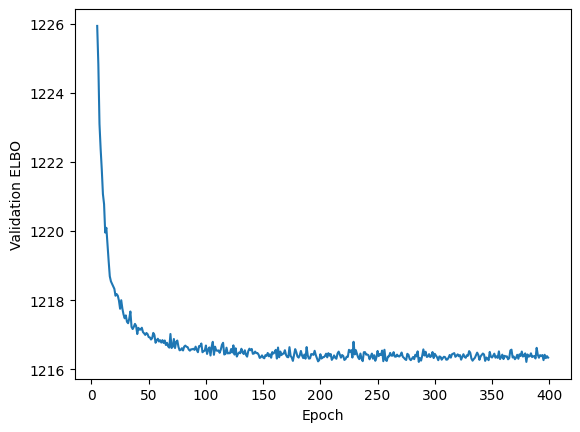

In [15]:
plt.plot(model.history["elbo_validation"].iloc[5:])
plt.xlabel("Epoch")
plt.ylabel("Validation ELBO")
plt.show()

In [16]:
adata.obs.columns

Index(['P7', 'P5', 'sample', 'n.umi', 'cell_ID', 'RT', 'Lig', 'new_cell',
       'oligo', 'Experiment', 'Drug', 'Dose', 'Tcell_Treatment', 'Replicate',
       'Well', 'hash_umis', 'total_hash_umis_per_cell_ID',
       'top_to_second_best_ratio', 'treatment', 'log10.umi', 'percent_mito',
       'drug_dose_treatment', 'dose_treatment', 'Size_Factor',
       'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index',
       'UMAP1', 'UMAP2', 'PCA_Cluster', 'APM_MHC_CI_score',
       'APM_MHC_CII_score', 'MKI67', 'Tcell_dose_response_score', '_indices',
       '_scvi_sample', '_scvi_batch', '_scvi_labels'],
      dtype='object')

In [17]:
model

Training status: Trained

In [18]:
dosage_colors = {
    "NoT": "#023047",
    "0.5T": "#FFD166",
}

In [19]:
adata.obs['Tcell_Treatment']

F01_A06_RT_BC_100_Lig_BC_12     NoT
F01_A06_RT_BC_100_Lig_BC_15    0.5T
F01_A06_RT_BC_100_Lig_BC_20    0.5T
F01_A06_RT_BC_100_Lig_BC_21    0.5T
F01_A06_RT_BC_100_Lig_BC_23     NoT
                               ... 
F12_H06_RT_BC_99_Lig_BC_60     0.5T
F12_H06_RT_BC_99_Lig_BC_63      NoT
F12_H06_RT_BC_99_Lig_BC_86     0.5T
F12_H06_RT_BC_99_Lig_BC_88     0.5T
F12_H06_RT_BC_99_Lig_BC_95      NoT
Name: Tcell_Treatment, Length: 98855, dtype: object

In [20]:
u = model.get_latent_representation()
adata.obsm["mrvi_u"] = u
sc.pp.neighbors(adata, use_rep='mrvi_u')
sc.tl.umap(adata, random_state=1)
fig = sc.pl.umap(adata, color=['drug_dose_treatment'], show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_u_embedding_treatment.pdf"), bbox_inches='tight')
plt.close(fig)

fig = sc.pl.umap(adata, color=['Drug'], show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_u_embedding_treatment_drug.pdf"), bbox_inches='tight')
plt.close(fig)



100%|██████████| 773/773 [00:02<00:00, 364.68it/s]


In [21]:

fig = sc.pl.umap(adata, color=['Tcell_Treatment'], show=False, return_fig=True, palette=dosage_colors)
plt.savefig(os.path.join(figure_dir, "mrvi_u_embedding_treatment_Tcell_treatment.pdf"), bbox_inches='tight')
plt.close(fig)

In [22]:
z = model.get_latent_representation(give_z=True)
adata.obsm["mrvi_z"] = z
sc.pp.neighbors(adata, use_rep='mrvi_z')
sc.tl.umap(adata, random_state=1)
fig = sc.pl.umap(adata, color=['drug_dose_treatment'], show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_z_embedding_treatment.pdf"), bbox_inches='tight')
plt.close(fig)
fig = sc.pl.umap(adata, color=['Drug'], show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_z_embedding_drug.pdf"), bbox_inches='tight')
plt.close(fig)

fig = sc.pl.umap(adata, color=['Tcell_Treatment'], show=False, return_fig=True, palette=dosage_colors)
plt.savefig(os.path.join(figure_dir, "mrvi_z_embedding_Tcell_treatment.pdf"), bbox_inches='tight')
plt.close(fig)

100%|██████████| 773/773 [00:02<00:00, 378.95it/s]


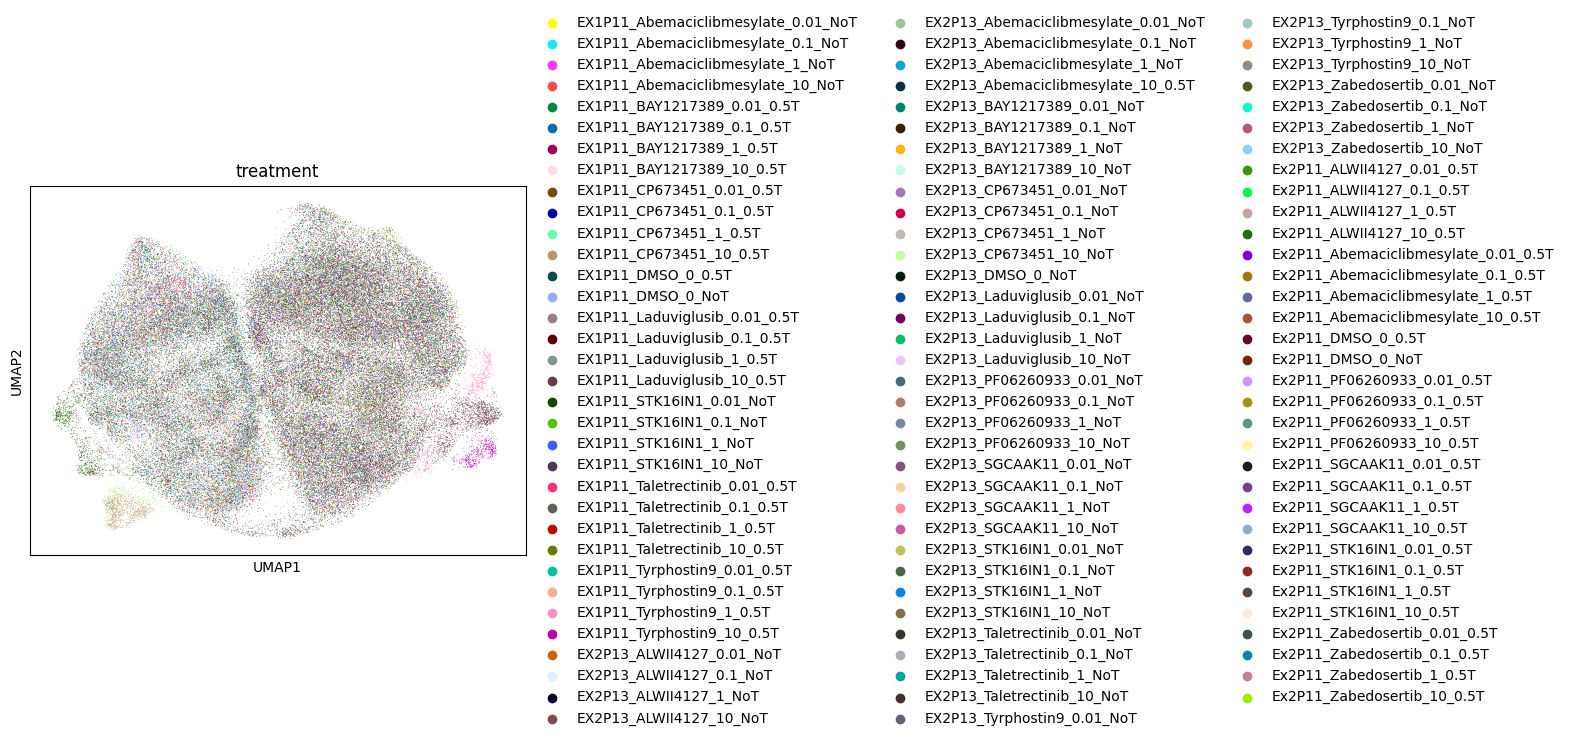

In [23]:
sc.pl.umap(adata, color=['treatment'])

NameError: name 'g' is not defined

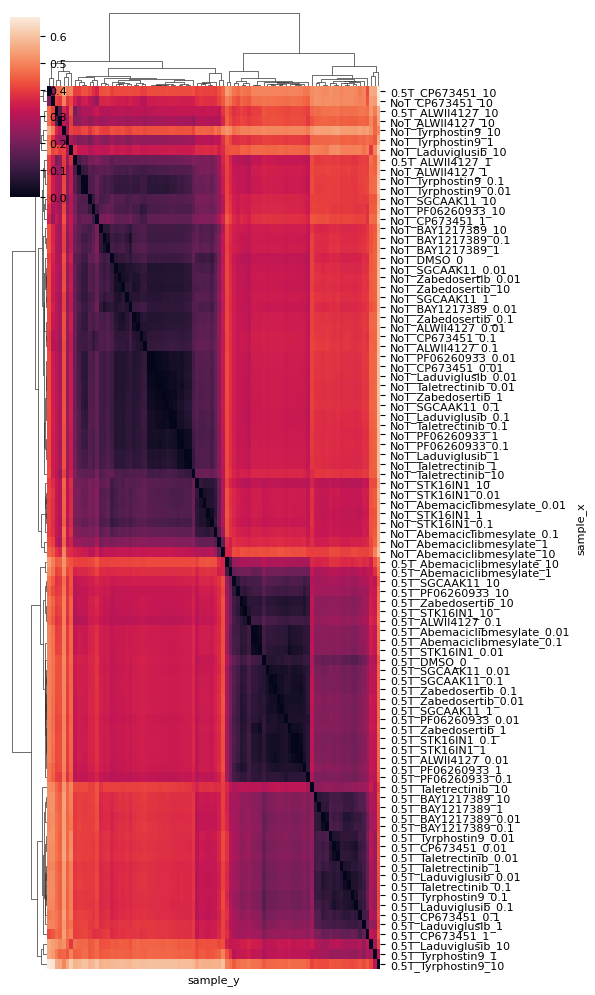

In [24]:
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'viridis'  # Or your preferred colormap
mpl.rcParams.update({'font.size': 8,
                    'svg.fonttype': 'none'})
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['xtick.labelsize'] = 8  # Colorbar tick label size 
mpl.rcParams['ytick.labelsize'] = 8  # Colorbar tick label size

dists_path = os.path.join(output_dir, f"_mrvi_treatment_drug_dists.nc")
if not os.path.exists(dists_path):
    dists = model.get_local_sample_distances(
        keep_cell=False, groupby = 'drug_dose_treatment', batch_size=32
    )
    dists.to_netcdf(dists_path)
else:
    dists = xr.open_dataset(dists_path)

from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering
from scipy.spatial.distance import squareform

def get_dendrogram(dists):
    ds = squareform(dists)
    Z = linkage(ds, method="ward")
    Z = optimal_leaf_ordering(Z, ds)
    return Z

d1 = dists.loc[{"drug_dose_treatment_name":  'NoT_DMSO_0'}].drug_dose_treatment
Z = get_dendrogram(d1)
sns.clustermap(
    d1.to_pandas(),
    row_linkage=Z,
    col_linkage=Z,
    xticklabels=False,
    yticklabels=True,
    figsize=(6, 10),
    dendrogram_ratio=(.1, .08)
)

# Remove axis labels
g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")

plt.savefig(os.path.join(figure_dir, f"mrvi_dendrogram.pdf"), bbox_inches='tight', dpi=300, transparent=True)
plt.savefig(os.path.join(figure_dir, f"mrvi_dendrogram.png"), bbox_inches='tight', dpi=300, transparent=True)
plt.savefig(os.path.join(figure_dir, f"mrvi_dendrogram.svg"), bbox_inches='tight', dpi=300, transparent=True)
plt.close()